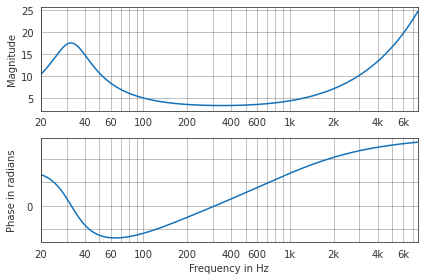

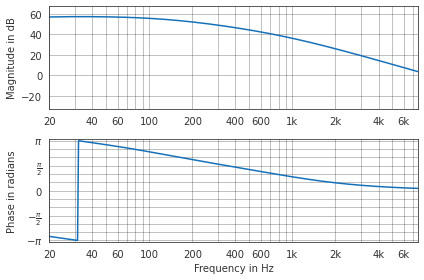

In [1]:
import pyfar
import numpy as np
import matplotlib.pyplot as plt

from pyfar import Signal
from lcapy import Circuit, s, f, Z
from numpy import linspace


fs = 15000          # s⁻¹
B = 1               # T
l = 17.188          # m
Sd = 1150e-4        # m²
rho0 = 1.2041       # kg / m³ 
c = 334.3           # m / s
V = 0.01            # m³

R = 3.3             # Ohm
L = 0.52e-3         # H

n = 164.62e-6       # m / N
w = 20.397          # Ns / m
m = 148.9e-3        # kg
w_v = 20            # Q / (omega * n_l)

plot_range_lin = linspace(0, fs/2, fs)    # Frequenzbereich und Auflösung


M   = B * l                          # Gyratorkonstante [N/A]
n_v = V / rho0 / pow(c, 2)           # Gehäusenachgiebigkeit V / (rho0 * c²)

_Rm  = pow(M, 2) / w                 # Ersatzwert für mechanische Reibung
_Cm  = m / pow(M, 2)                 # Ersatzwert für mechanische Masse
_Lm  = pow(M, 2) * n                 # Ersatzwert für mechanische Nachgiebigkeit
_Ra = pow(M, 2) / pow(Sd, 2) / w_v   # Impedanz Membranvorderseite
_La = pow(M, 2) / pow(Sd, 2) / n_v   # Nachgiebigkeit durch geschlossenes Gehäuse


# Auf elektrische Seite transformiertes Ersatzschaltbild

cct = Circuit("""
    Re 1 3 %f; right
    Le 3 4 %f; right
    GY 5 0 4 0 %f; right
    Rm 5 6 %f; down
    Cm 6 7 %f; down
    Lm 7 8 %f; down
    TF 8 0 2 0 %f; down
    Ca 2 0 %f; down
    Ra 2 0 %f; down
    """ % (R, L, M, w, n, m, Sd, n_v, w_v))


def input_impedance():
    """Calculates the input impedance of the model and returns it as a pyfar signal.

    Parameters
    ----------

    Returns
    -------
    sig : pyfar.Signal object
        Pyfar Signal containing the input impedance
    """

    Z_in = cct.impedance(1)
    sig = Signal(Z_in(f).evaluate(plot_range_lin), sampling_rate = fs, domain = 'freq')

    return sig


def transfer_function():
    """Calculates the transfer function of the model (sound pressure over input voltage) and returns it as a pyfar signal.

    Parameters
    ----------
    
    Returns
    -------
    sig : pyfar.Signal object
        Pyfar Signal containing the transfer function
    """

    H = cct.transfer(1, 0, 2, 0).frequency_response() / _Ra * M / Sd 
    sig = Signal(H(f).evaluate(plot_range_lin), sampling_rate = fs, domain = 'freq')

    return sig

plt.figure()
pyfar.plot.line.freq_phase(input_impedance(), dB = False)
plt.show()
plt.figure()
pyfar.plot.line.freq_phase(transfer_function(), dB = True, log_reference = 20e-6)
plt.show()